# HW 5 part 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.signal as sig
import scipy.stats as stats
import sklearn.linear_model as lm
import statsmodels.api as sm

In [ ]:
best = xr.open_dataset('/content/drive/MyDrive/Classes/OA/HW5/BEST-1950-2018-monthlyTemp.nc')

About the CDI data:
* 3 variables: temperature, land_mask, and climatology
* 1 deg by 1 deg grids
* 3 dimensions: time, latitude, longitude

## Get climatology

In [ ]:
def weighted_avg(data, lat_range):
    weights = np.cos(np.deg2rad(lat_range))
    data_weighted = data.weighted(weights)
    weighted_avg = data_weighted.mean(["longitude", "latitude"])
    return weighted_avg

In [ ]:
# calculate climatology
def get_climatology(data):
  climatology = data.groupby(data.time.dt.month).mean("time")
  return climatology.sortby("month")

In [ ]:
climate = get_climatology(best.temperature)
cli_SH = climate.sel(latitude=slice(-90,-60))
cli_NH = climate.sel(latitude=slice(60,90))

In [ ]:
# fig, ax = plt.subplots(1, 1, dpi=100)
# ax.plot(climate.month, climate.isel(latitude=40).isel(longitude=20))

## Remove mean

In [ ]:
# calculate t star by grid and month for each hemi
Tstar_NH = best.temperature.sel(latitude=slice(60, 90)).groupby("time.month") - cli_NH
Tstar_SH = best.temperature.sel(latitude=slice(-90,-60)).groupby("time.month") - cli_SH

# calculate weighted average for each hemi
X_NH = weighted_avg(Tstar_NH, Tstar_NH.latitude)
X_SH = weighted_avg(Tstar_SH, Tstar_SH.latitude)

## Plot of T'

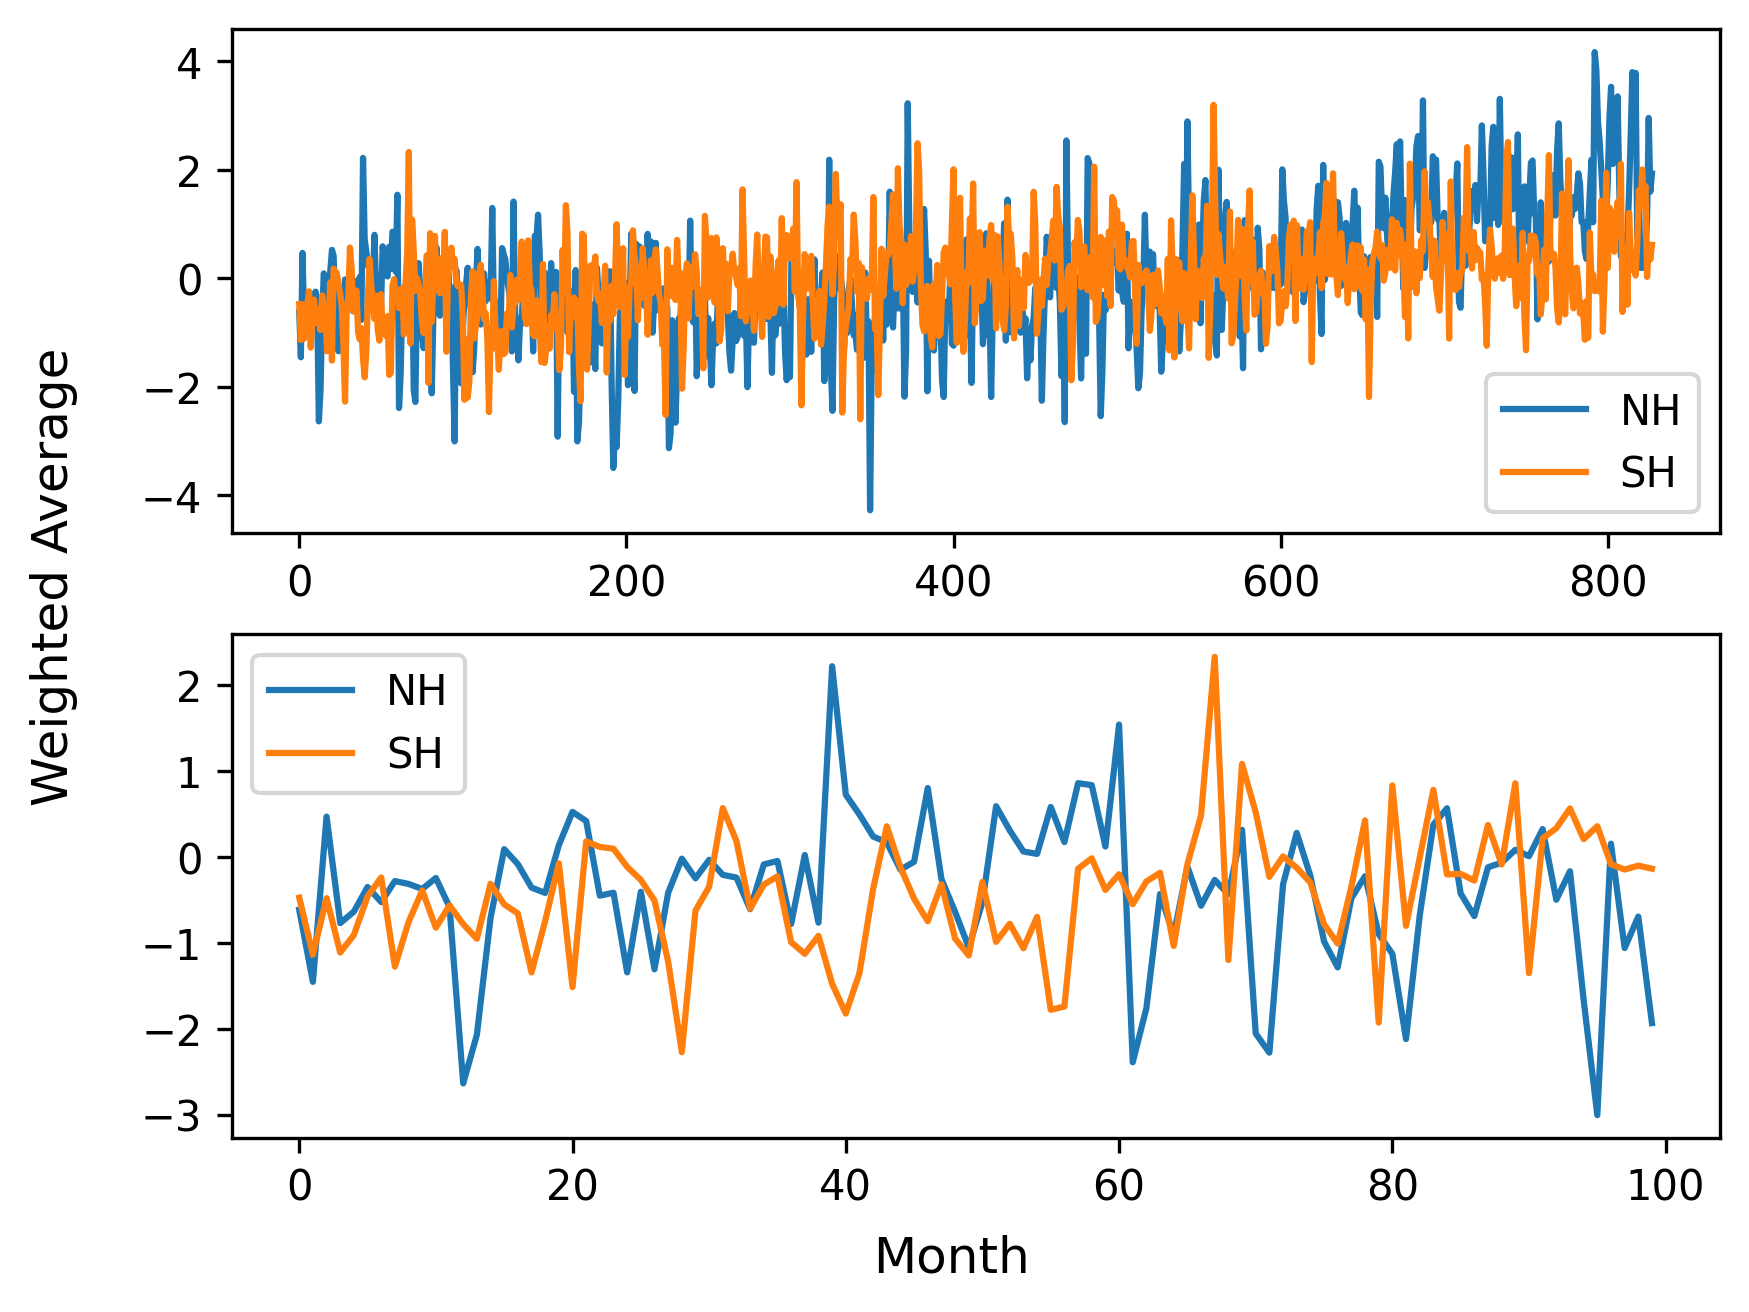

In [ ]:
# plot the data
fig, ax = plt.subplots(2, 1, dpi=300)
ax[0].plot(np.arange(len(X_NH)), X_NH, label='NH')
ax[0].plot(np.arange(len(X_NH)), X_SH, label='SH')
ax[0].legend()
ax[1].plot(np.arange(len(X_NH))[0:100], X_NH[0:100], label='NH')
ax[1].plot(np.arange(len(X_NH))[0:100], X_SH[0:100], label='SH')
ax[1].legend()
fig.supylabel('Weighted Average')
fig.supxlabel('Month')
plt.show()

In [ ]:
# # is there a trend? YES
# NH_reg = lm.LinearRegression().fit(np.arange(len(X_NH)).reshape(-1, 1), X_NH)
# print(NH_reg.coef_)

# SH_reg = lm.LinearRegression().fit(np.arange(len(X_NH)).reshape(-1, 1), X_SH)
# print(SH_reg.coef_)

[0.00269601]
[0.00128342]


In [ ]:
# # remove linear trend
# X_NH = X_NH - NH_reg.predict(np.arange(len(X_NH)).reshape(-1, 1))
# X_SH = X_SH - SH_reg.predict(np.arange(len(X_NH)).reshape(-1, 1))

In [ ]:
# # replot
# # plot the data
# fig, ax = plt.subplots(2, 1, dpi=300)
# ax[0].plot(np.arange(len(X_NH)), X_NH, label='NH')
# ax[0].plot(np.arange(len(X_NH)), X_SH, label='SH')
# ax[0].legend()
# ax[1].plot(np.arange(len(X_NH))[0:100], X_NH[0:100], label='NH')
# ax[1].plot(np.arange(len(X_NH))[0:100], X_SH[0:100], label='SH')
# ax[1].legend()
# fig.supylabel('Weighted Average')
# fig.supxlabel('Month')
# plt.show()

## Get power spectrums individually

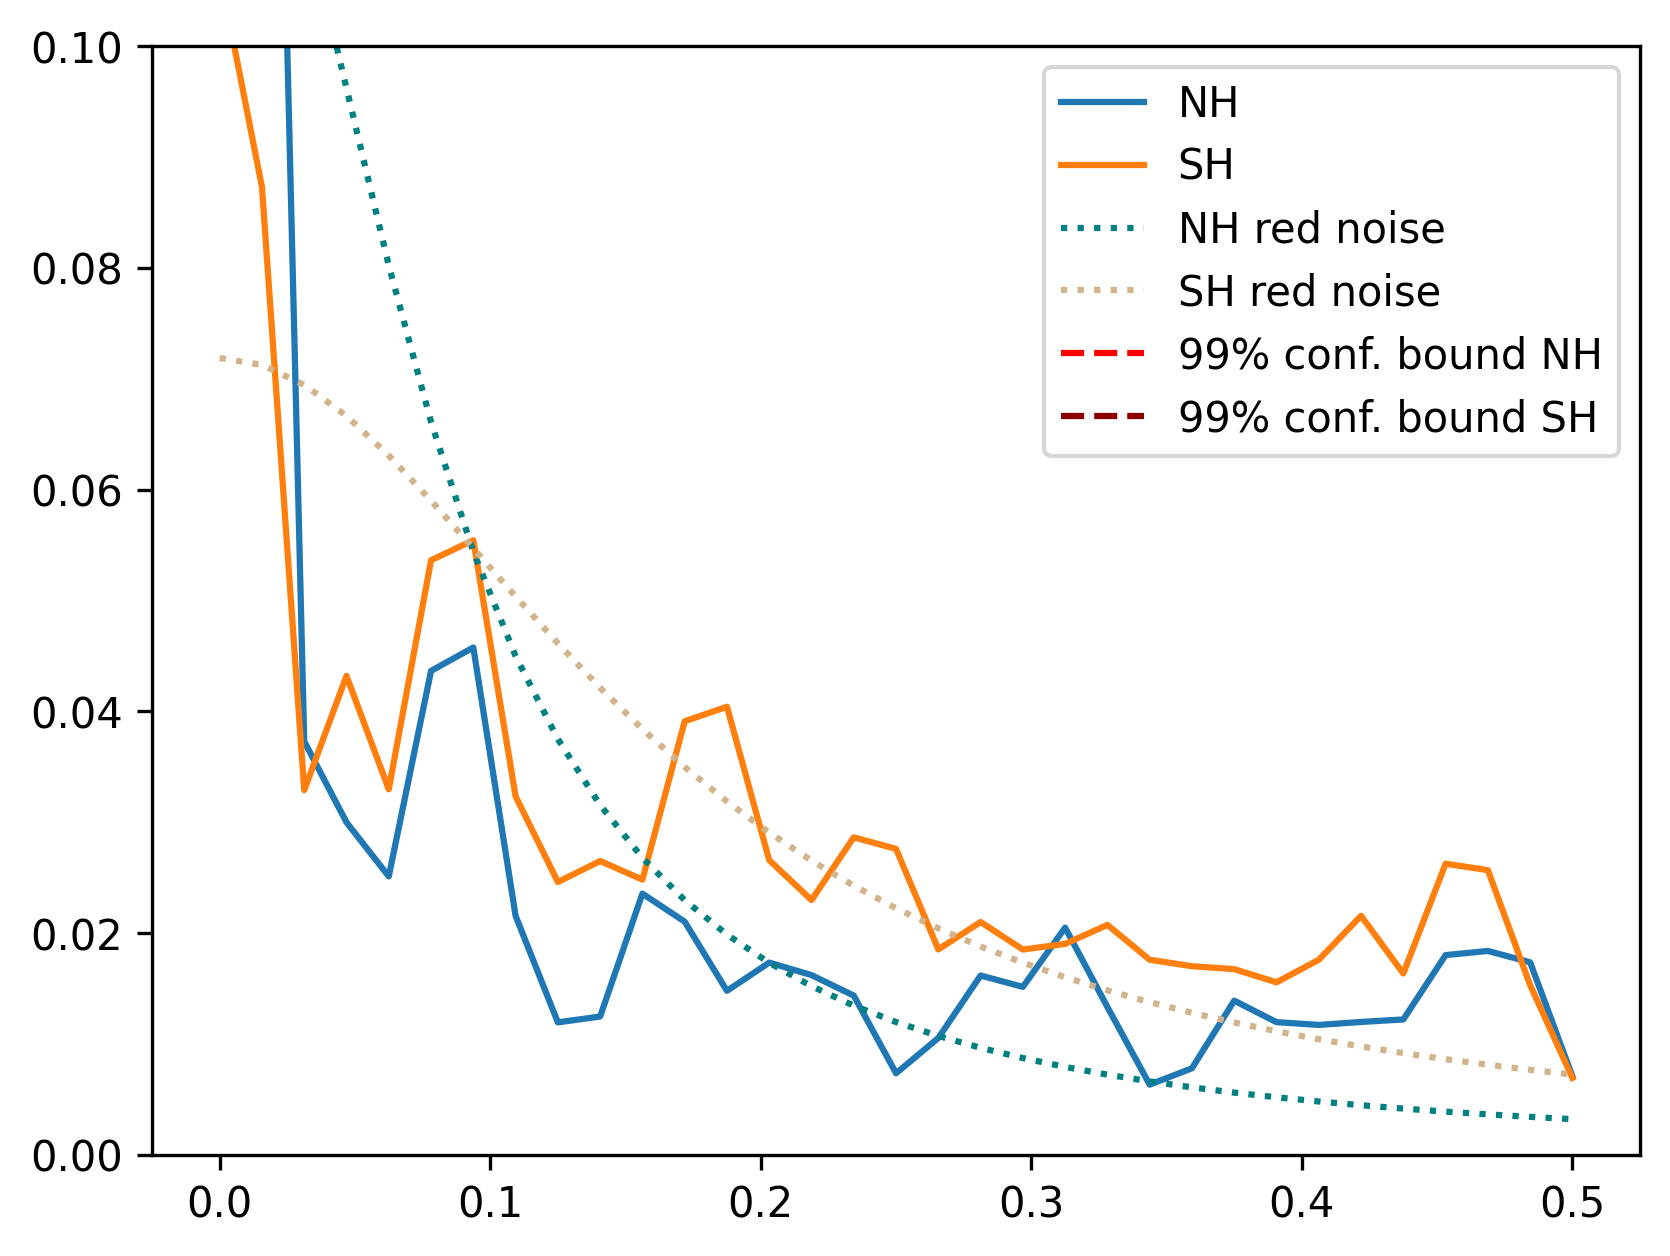

In [281]:
m = 64
N = len(X_NH)//m

# get the power series of each X
F_NH, P_NH = sig.csd(
    X_NH,
    X_NH,
    window='hann',
    noverlap=0,
    nperseg=m,
    nfft=m,
    scaling="density",
    detrend=None,
)

F_SH, P_SH = sig.csd(
    X_SH,
    X_SH,
    window='hann',
    noverlap=0,
    nperseg=m,
    nfft=m,
    scaling="density",
    detrend=None,
)

# NH red noise
alpha = sig.correlate(X_NH, X_NH, "full")
alpha = alpha / np.max(alpha)
alpha = alpha[int(np.size(alpha) / 2) + 1]
Te = -1.0 / np.log(alpha)
rnoise = 2.8 * 2 * Te / (1 + (Te**2) * (F_NH * 2 * np.pi) ** 2)
rnoise_NH = rnoise / np.sum(rnoise)

# SH red noise
alpha = sig.correlate(X_SH, X_SH, "full")
alpha = alpha / np.max(alpha)
alpha = alpha[int(np.size(alpha) / 2) + 1]
Te = -1.0 / np.log(alpha)
rnoise = 2.8 * 2 * Te / (1 + (Te**2) * (F_SH * 2 * np.pi) ** 2)
rnoise_SH = rnoise / np.sum(rnoise)

# add 99 percent bound with chi-squared stat
dof = 2*len(X_NH)/m
f = stats.chi2.ppf(0.99, dof)

fig, ax = plt.subplots(1, 1, dpi=300)
ax.plot(F_NH, P_NH/np.sum(P_NH), label='NH')
ax.plot(F_SH, P_SH/np.sum(P_SH), label='SH')
ax.plot(F_NH, rnoise_NH, linestyle=':', label='NH red noise', c='teal')
ax.plot(F_SH, rnoise_SH, linestyle=':', c='tan', label='SH red noise')
# ax.plot(F_NH, rnoise_NH*f, linestyle='--', label='99% conf. bound NH', c='r')
# ax.plot(F_SH, rnoise_SH*f, linestyle='--', c='darkred', label='99% conf. bound SH')
ax.set_ylim(0, 0.1)
ax.legend()
plt.show()

## Cross spectrum and $coh^2$

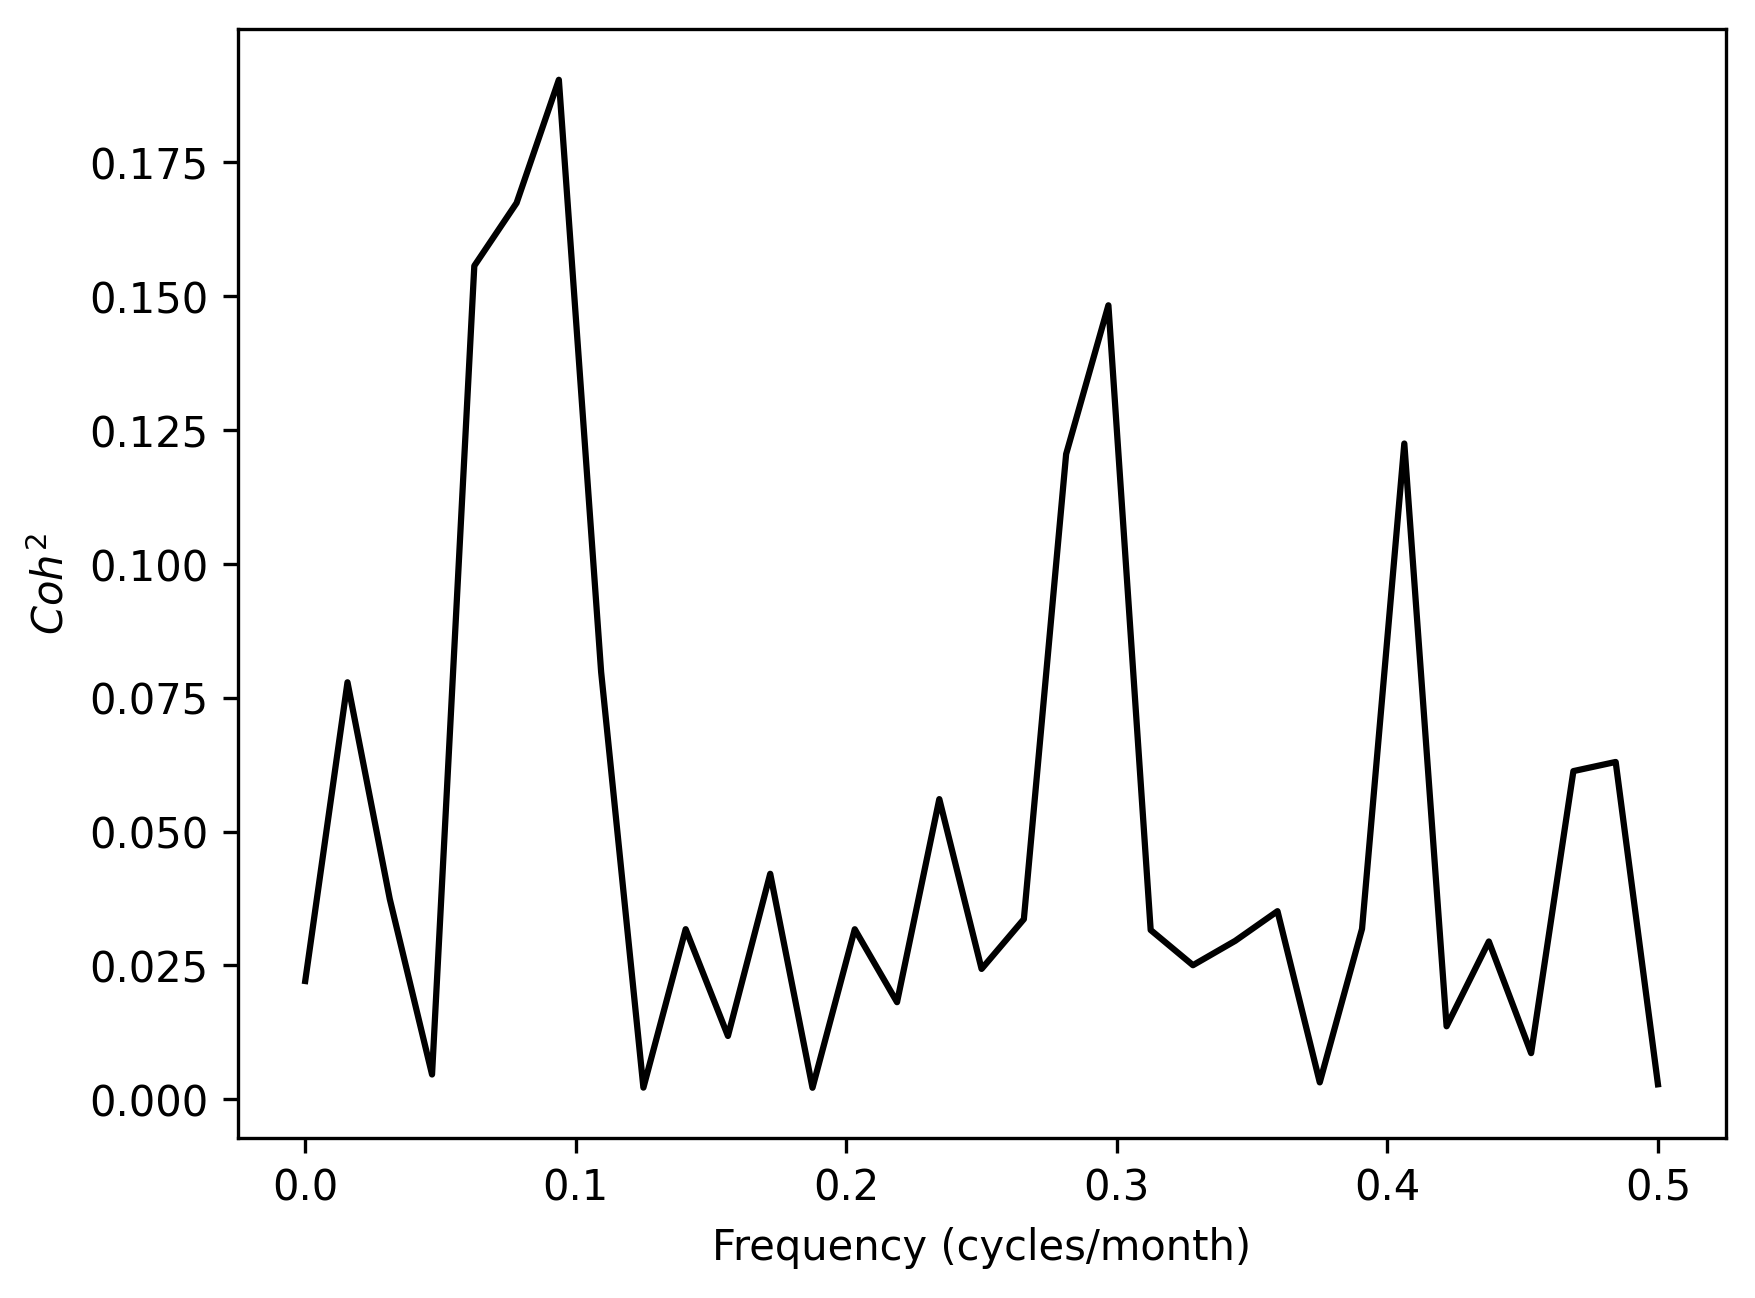

In [313]:
m = 64
N = len(X_NH)//m

# cross spectral analysis
F, C_NS = sig.coherence(
    X_NH,
    X_SH,
    window='hann',
    noverlap=None,
    nperseg=m,
    nfft=m,
    detrend='linear',
)

plt.figure(dpi=300)
plt.plot(F, C_NS, "k")
plt.ylabel("$Coh^2$")
plt.xlabel("Frequency (cycles/month)")
plt.show()

## Statistical significance

In [314]:
# sort the peaks
j = np.argsort(C_NS)[::-1]

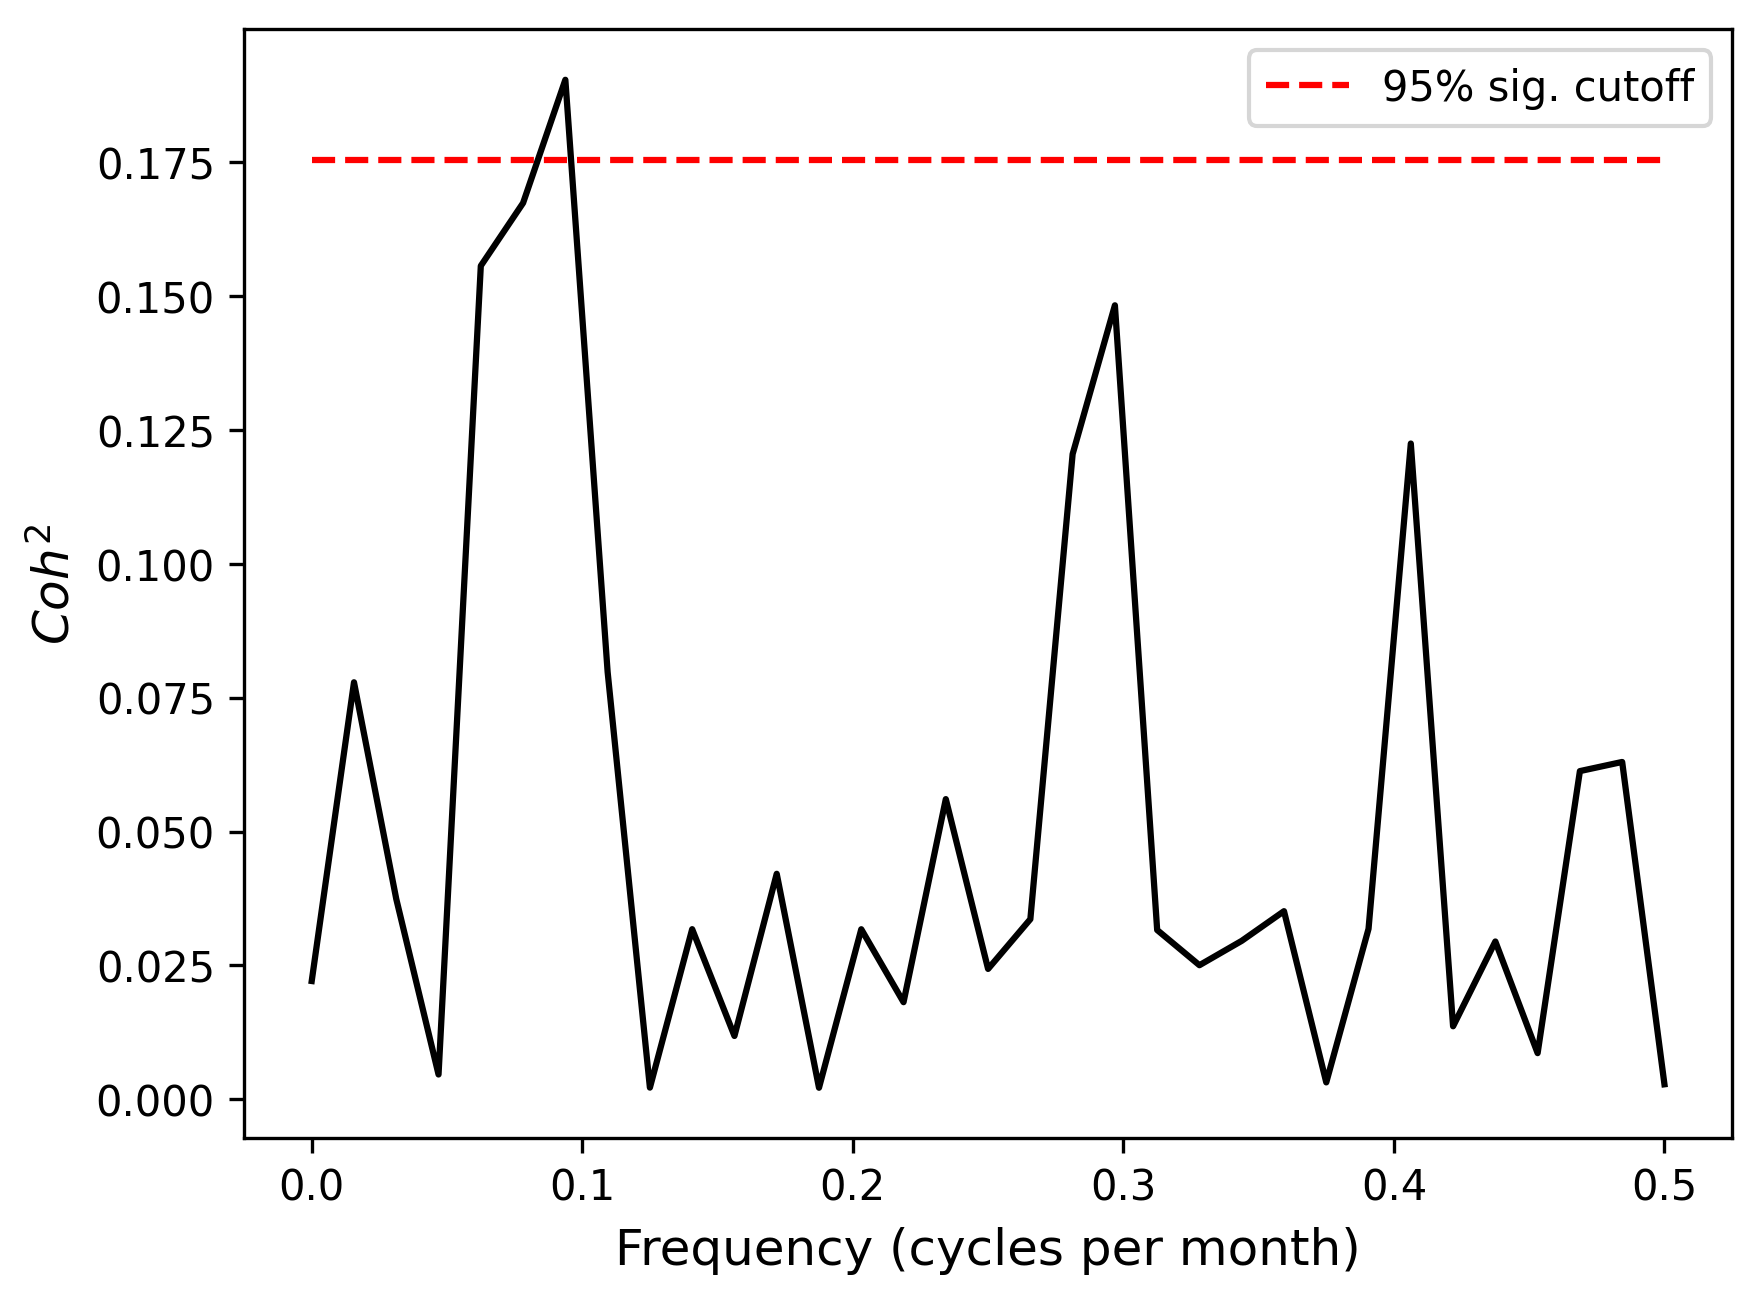

In [317]:
plt.figure(dpi=300)
plt.plot(F, C_NS, "-k",)

plt.ylabel("$Coh^2$", fontsize=12)
plt.xlabel("Frequency (cycles per month)", fontsize=12)

dof = 2*len(X_NH)/m
fval = stats.f.ppf(0.90, 2, dof - 2)
r2_cutoff = 2.*fval / (dof - 2.0 + 2.*fval)
plt.plot(F, np.ones(np.size(F)) * r2_cutoff, "--r", label="95% sig. cutoff")
plt.legend()
# plt.title("Coherence Squared")
plt.show()

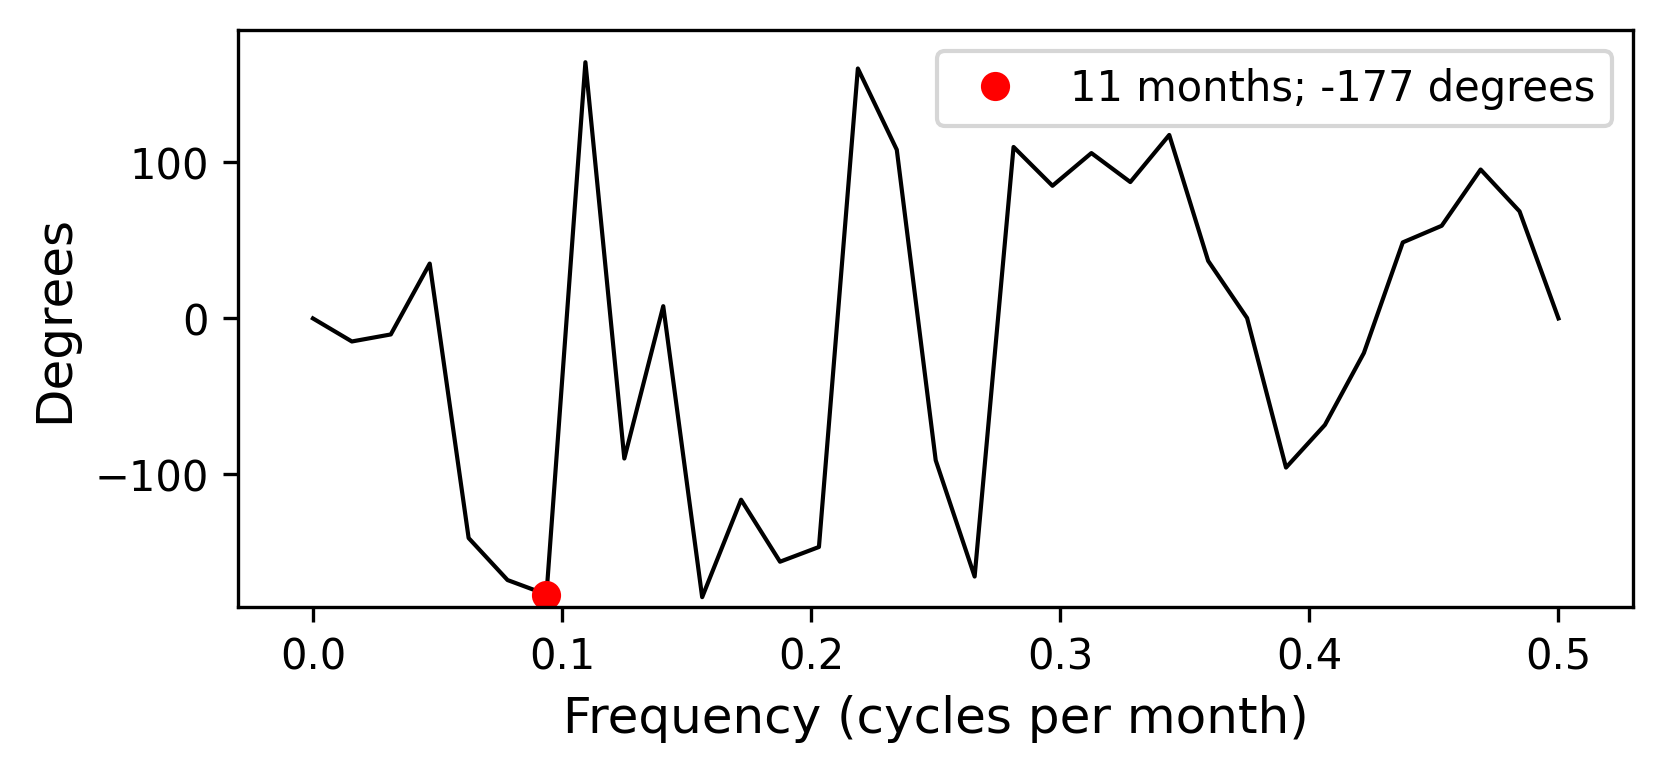

-------------------------------------
            PERIOD ........... PHASE
   RED:     11.0 months        -177.0 deg.


In [316]:
F, P_NS = sig.csd(
    X_NH,
    X_SH,
    window='hann',
    noverlap=None,
    nperseg=m,
    nfft=m,
    scaling="density",
    detrend=False,
)

# caculate the quadrature spectrum (phase)
P = -np.angle(P_NS, deg=True)

# %% plot the quadrature spectrum
plt.figure(figsize=(6, 2.5),dpi=300)
plt.plot(F, P, "-k", linewidth=1)
plt.plot(F[j[0]], P[j[0]], "or", label='11 months; -177 degrees')

# plt.title("Phase difference")
plt.ylabel("Degrees", fontsize=12)
plt.xlabel("Frequency (cycles per month)", fontsize=12)
plt.xlim(-0.03, 0.53)
plt.ylim(-185, 185)
plt.legend()
plt.show()

print("-------------------------------------")
print("            PERIOD ........... PHASE")
print(
    "   RED:     "
    + str(np.round(1.0 / F[j[0]], 0))
    + " months        "
    + str(np.round(P[j[0]]))
    + " deg."
)

In [291]:
P[j[1]]

np.float32(159.2504)

## Changing realization length

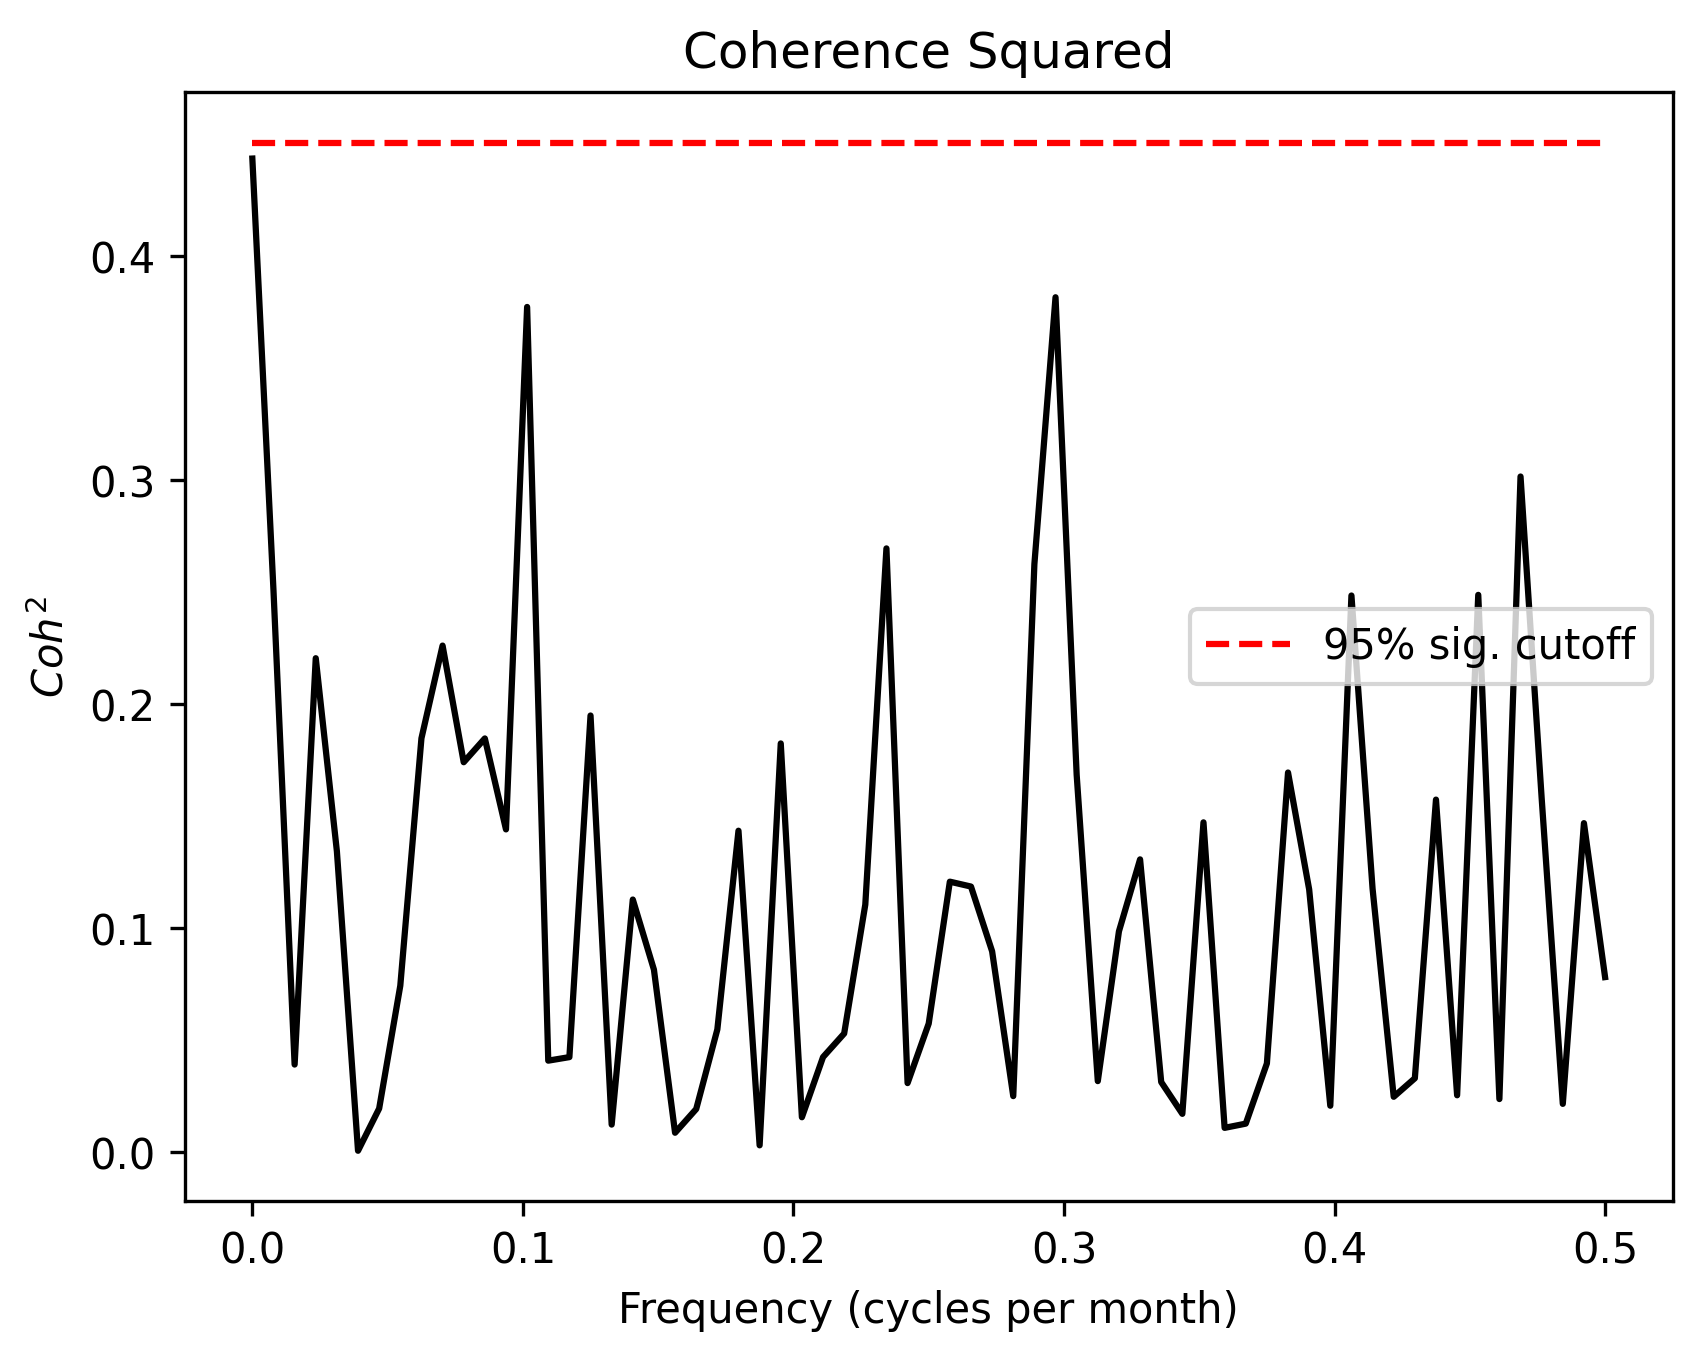

In [318]:
m = 128
N = len(X_NH)//m
# cross spectral analysis
F, C_NS = sig.coherence(
    X_NH,
    X_SH,
    window='hann',
    noverlap=None,
    nperseg=m,
    nfft=m,
    detrend=None,
)

plt.figure(dpi=300)
plt.plot(F, C_NS, "-k",)

plt.ylabel("$Coh^2$")
plt.xlabel("Frequency (cycles per month)")

dof = 2*N
fval = stats.f.ppf(0.95, 2, dof - 2)
r2_cutoff = 2.*fval / (dof - 2.0 + 2.*fval)
plt.plot(F, np.ones(np.size(F)) * r2_cutoff, "--r", label="95% sig. cutoff")
plt.legend()
plt.title("Coherence Squared")
plt.show()

In [308]:
N

6

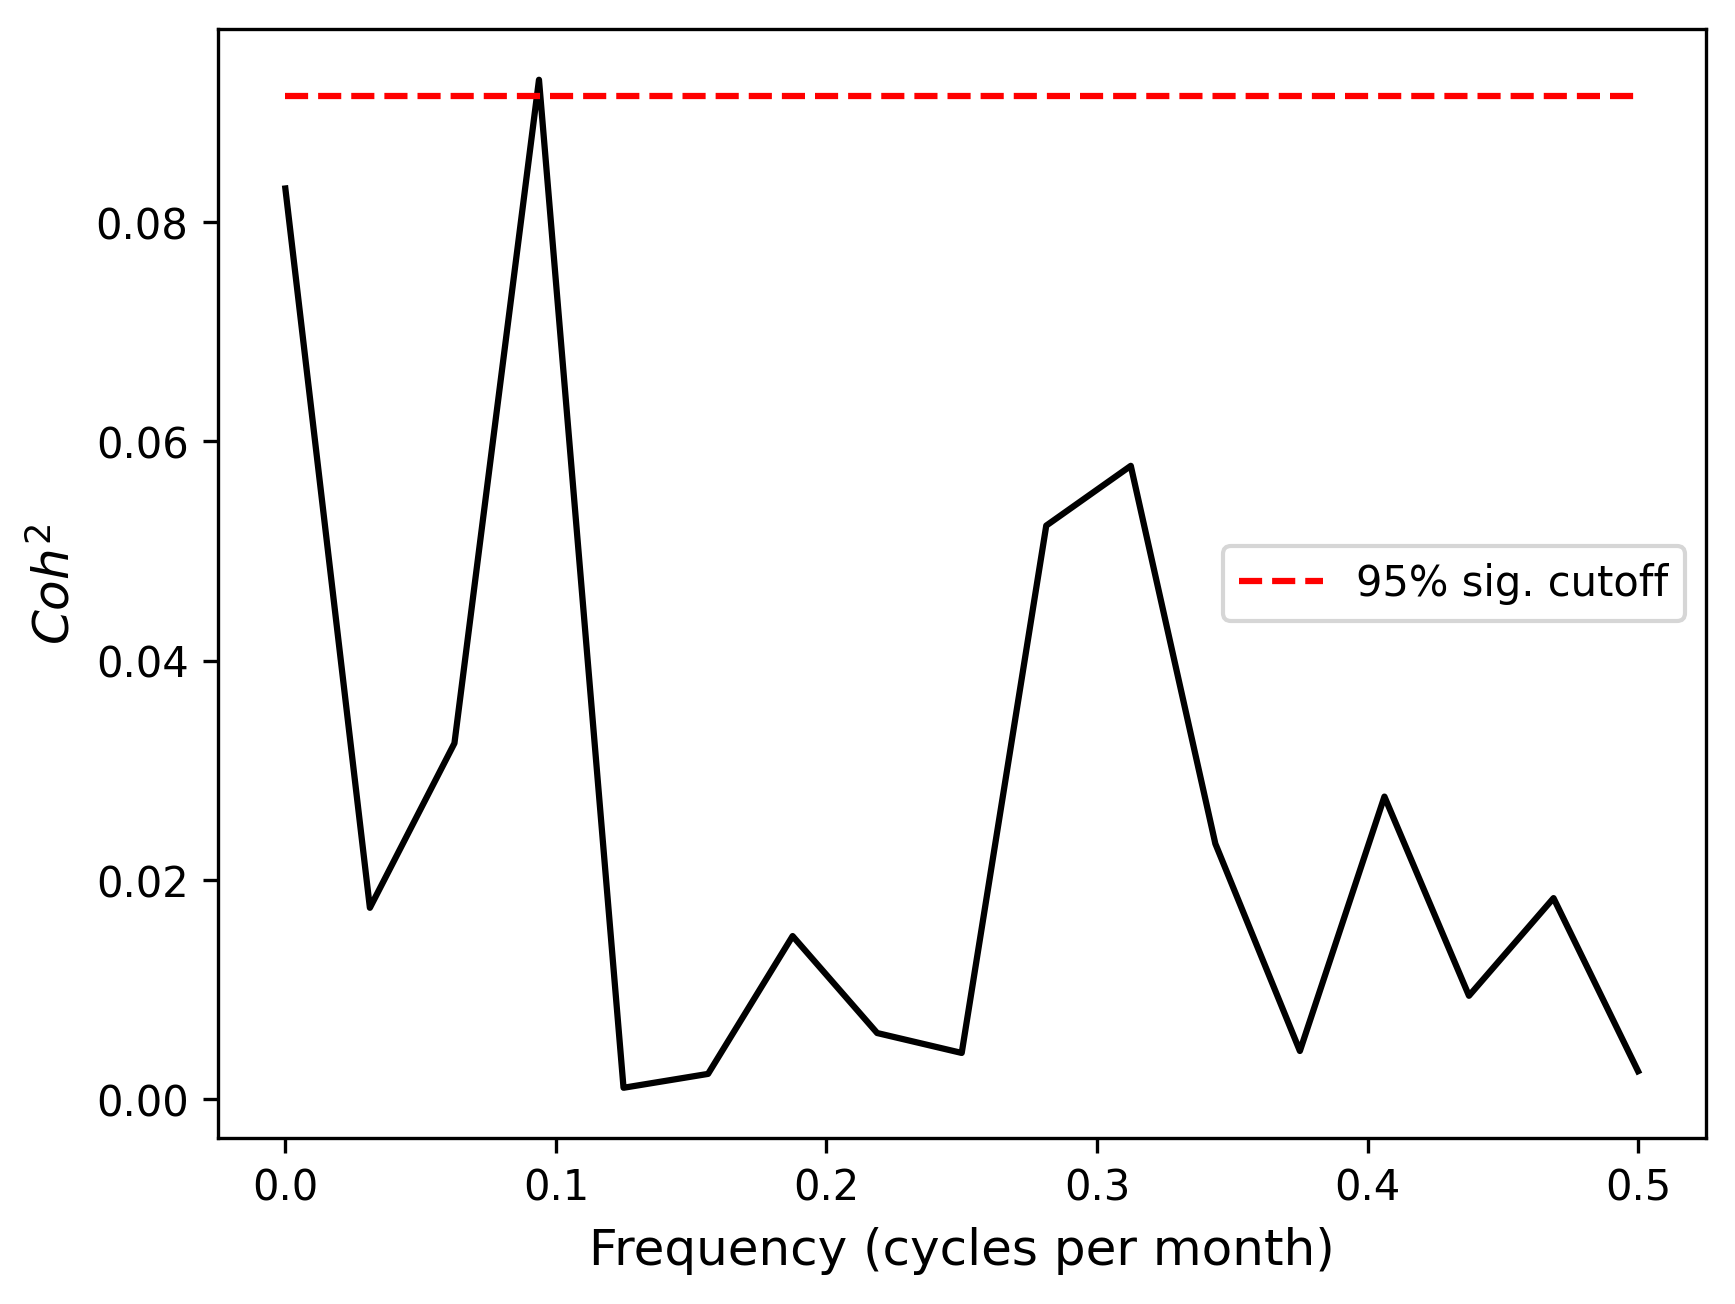

In [319]:
m = 32
N = len(X_NH)//m
# cross spectral analysis
F, C_NS = sig.coherence(
    X_NH,
    X_SH,
    window='hann',
    noverlap=None,
    nperseg=m,
    nfft=m,
    detrend='linear',
)

plt.figure(dpi=300)
plt.plot(F, C_NS, "-k",)

plt.ylabel("$Coh^2$", fontsize=12)
plt.xlabel("Frequency (cycles per month)", fontsize=12)

dof = 2*N
fval = stats.f.ppf(0.90, 2, dof - 2)
r2_cutoff = 2.*fval / (dof - 2.0 + 2.*fval)
plt.plot(F, np.ones(np.size(F)) * r2_cutoff, "--r", label="95% sig. cutoff")
plt.legend()
# plt.title("Coherence Squared")
plt.show()

In [310]:
N

25